<a href="https://colab.research.google.com/github/Div12345/SleepStaging-TransferLearning/blob/main/Blanco2020_Model_Sleep_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blanco et al. 2020 Model
[Paper](https://arxiv.org/ftp/arxiv/papers/2103/2103.16215.pdf)

# Setup

In [ ]:
#@title Dependencies Install
!pip install wandb
!pip install git+https://github.com/sylvchev/beetl-competition
!pip install moabb
!pip install braindecode
!pip install git+https://github.com/pyRiemann/pyRiemann
!pip install matplotlib
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

In [ ]:
#@title Imports
from mne import get_config, set_config
import os.path as osp
import os
from beetl.task_datasets import BeetlSleepLeaderboard, BeetlSleepSource
import numpy as np
import pandas as pd
import mne

import braindecode
from braindecode import EEGClassifier
from braindecode.util import np_to_var, set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode.datautil.preprocess import preprocess, Preprocessor, zscore
from braindecode.samplers.ssl import RelativePositioningSampler
#from braindecode.datautil import create_from_X_y
from braindecode.datasets import BaseDataset

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import skorch
import skorch.dataset
from skorch.callbacks import EarlyStopping, Checkpoint, EpochScoring, WandbLogger, TrainEndCheckpoint
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from skorch.classifier import NeuralNetClassifier as NNClassifier

import time
import math
import copy
from copy import deepcopy

import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchsampler import ImbalancedDatasetSampler as IDS

import wandb

import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Optional wandb for model logging
!wandb login
# Specific to user - Put it here for convinience

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
mne.set_log_level(False) # Equivalent to WARNING
path = "/content/drive/MyDrive/mne_data"
set_config("MNE_DATA", path)
set_config("MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH",path)
set_config("MNE_DATASETS_BEETLSLEEPSOURCE_PATH",path)
get_config()

<ipython-input-4-d9ce88047e42>:4: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH"
  set_config("MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH",path)
<ipython-input-4-d9ce88047e42>:5: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BEETLSLEEPSOURCE_PATH"
  set_config("MNE_DATASETS_BEETLSLEEPSOURCE_PATH",path)


{'MNE_DATA': '/content/drive/MyDrive/mne_data',
 'MNE_DATASETS_BEETLSLEEPLEADERBOARD_PATH': '/content/drive/MyDrive/mne_data',
 'MNE_DATASETS_BEETLSLEEPSOURCE_PATH': '/content/drive/MyDrive/mne_data'}

In [ ]:
cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if cuda else 'cpu'
print(device)
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=87, cuda=cuda)
random_state = 87

!nvidia-smi -L
# !nvidia-smi -q

# gpu = cuda.get_current_device()
# print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))

cuda
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c3e06580-ab8e-2ffd-1dc1-f3ea7be7b9c2)


In [ ]:
#@title Helper Functions

def label_count(y_train):
  labels= np.unique(y_train)
  labelsize=labels.shape[0]
  #print('labelsize:',labelsize)
  label_count = np.zeros(labelsize).astype(int)
  for i in range(labelsize):
      # tempy = ys1[ys1==labels[i]]
      label_count[i]=y_train[y_train==labels[i]].shape[0]
  maxsize = label_count.max()
  print(label_count)
  return np_to_var(label_count)

def label_viz(y):
  # Another Nice func with viz
  classes_mapping = {0: 'W', 1: 'S1', 2: 'S2', 3: 'S3', 4: 'S4', 5:'REM'}
  # This might be a time consuming method though
  y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
  ax = y_train.value_counts().plot(kind='barh')
  ax.set_xlabel('Number of training examples');
  ax.set_ylabel('Sleep stage');

# For trained Skorch model
def training_viz(clf):
  # For Trained Skorch Classifier
  df = pd.DataFrame(clf.history.to_list())
  df[['train_mis_clf', 'valid_mis_clf']] = 100 - df[
      ['train_bacc', 'valid_bacc']] * 100

  # get percent of misclass for better visual comparison to loss
  plt.style.use('seaborn-talk')
  fig, ax1 = plt.subplots(figsize=(20, 7))
  df.loc[:, ['train_loss', 'valid_loss']].plot(
      ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False,
      fontsize=14)

  ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
  ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  df.loc[:, ['train_mis_clf', 'valid_mis_clf']].plot(
      ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
  ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
  ax2.set_ylabel('Balanced misclassification rate [%]', color='tab:red',
                fontsize=14)
  ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
  ax1.set_xlabel('Epoch', fontsize=14)

  # where some data has already been plotted to ax
  handles = []
  handles.append(
      Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
  handles.append(
      Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
  plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
  plt.tight_layout()

# Scaling the data
class TrainObject(object):
    # Scaling the data
    def __init__(self, X, y, nps= False):
        assert len(X) == len(y)
        # mean = np.mean(X, axis=2, keepdims=True)
        # # Here normalise across the window, when channel size is not large enough
        # # In motor imagery kit, we put axis = 1, across channel as an example
        # std = np.std(X, axis=2, keepdims=True)
        # X = (X - mean) / std
        X = zscore(X)
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        if (nps == False):
          self.X = np_to_var(X.astype(np.float32)*1e3).to(device)
          self.y = np_to_var(y.astype(np.int8)).to(device)
        else:
          self.X = X.astype(np.float32)*1e3
          self.y = y.astype(np.int8)

def predict_leaderboard_unlabelled(clf, save_fname, x_test_data = None, emb = False,nps=False):
  # Test Data - 6 to 17 - 12 subjects 
  if x_test_data is None:
    _, _, X_test, _ = dsl.get_data(subjects=range(6, 18)) 
    print("Sleep leaderboard - Test Data : There are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

    # print(X_test.shape[0])

    x_test_mean = TrainObject(X_test, y = np.zeros(X_test.shape[0]),nps=nps)
    if (nps==False):
      # means torch must've been the input to the classifier
      x_test_data = Dataset(x_test_mean.X,x_test_mean.y)
      # Maybe put a tqdm bar?
      y_pred = clf.predict(x_test_data)
    else:
      x_test_data = x_test_mean 
      y_pred = clf.predict(x_test_data.X)
  else:
    y_pred = clf.predict(x_test_data)
  print(x_test_data.shape)

  print("Checking if all classes have been predicted")
  print(np.unique(y_pred))
  #@markdown Set the save_path for saving the prediction
  save_path = "/content/drive/MyDrive/mne_data/NeuroIPS_Hack_Sleep/predict/" #@param
  np.savetxt(save_path+save_fname+".txt",y_pred,delimiter=',',fmt="%d")

In [ ]:
#@title Helper Functions for loading the Data
def get_trainB():
  start = time.time()
  dss = BeetlSleepSource()
  
  start = time.time()
  X_train, y_train, _ = dss.get_data()
  end = time.time()

  print(f"Train data load time {(end-start)/60} min")
  print(X_train.shape,y_train.shape)
  label_count(y_train)

  # z-scoring or normalizing
  
  # start = time.time()
  trainX = TrainObject(X_train, y = y_train, nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start}")
  
  start = time.time()
  # trainB = Dataset(trainX)
  trainB = Dataset(trainX.X,trainX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  # 10 sec + 7 min
  return trainB

def get_valB():
  # valB
  # Labelled Leaderboard Data
  start = time.time()
  dsl = BeetlSleepLeaderboard()
  # dsl.get_data()

  # Validation Data - 5? 6? subjects from the test group - Competition says 5, looks like 6

  X_target, y_target, _, _ = dsl.get_data(subjects=range(0,6))

  end = time.time()
  print(f"leaderboard labelled load time = {(end-start)/60} min")

  print(X_target.shape,y_target.shape)
  label_count(y_target)

  # z-scoring or normalizing
  start = time.time()
  valX = TrainObject(X_target, y = y_target, nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")

  
  # for braindecode
  start = time.time()
  valB = Dataset(valX.X,valX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  # 3 sec + 1.5 min
  return valB

def get_testB():
  dsl = BeetlSleepLeaderboard()
  _, _, X_test, _ = dsl.get_data(subjects=range(6, 18)) 
  print("Sleep leaderboard - Test Data : There are {} trials with {} electrodes and {} time samples".format(*X_test.shape))
  # print(X_test.shape[0])
  # x_test_mean = TrainObject(X_test, y = np.zeros(X_test.shape[0]),nps=nps)

  # z-scoring or normalizing
  start = time.time()
  testX = TrainObject(X_test, y = np.zeros(X_test.shape[0]), nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")
  
  # for braindecode
  start = time.time()
  testB = Dataset(testX.X,testX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  return testB

def get_valC():
  # Phase 2 Target Data
  # Need to download by myself first
  target_savebase = '/content/drive/MyDrive/mne_data/MNE-beetlsleeptest-data/sleep_target/'
  X_sleep_target = []
  y_sleep_target = []
  #from s0-s4 in final set
  start = time.time()
  for subj in range(0, 5):
      for session in range(1, 3):
          # "testing_s{}r{}X.npy", replacing "leaderboard_s{}r{}X.npy" before
          with open(target_savebase + "testing_s{}r{}X.npy".format(subj, session), 'rb') as f:
            X_sleep_target.append(pickle.load(f))
          with open(target_savebase + "testing_s{}r{}y.npy".format(subj, session), 'rb') as g:
            y_sleep_target.append(pickle.load(g))
  X_sleep_target = np.concatenate(X_sleep_target)
  y_sleep_target = np.concatenate(y_sleep_target)


  end = time.time()
  print(f"phase 2 labelled load time = {(end-start)/60} min")

  print("There are {} trials with {} electrodes and {} time samples".format(*X_sleep_target.shape))
  print(X_sleep_target.shape, y_sleep_target.shape)
  label_count(y_sleep_target)

  # package in torch dataset with mean normalizing
  # z-scoring or normalizing
  start = time.time()
  valX = TrainObject(X_sleep_target, y = y_sleep_target, nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")

  
  # for braindecode
  start = time.time()
  valC = Dataset(valX.X,valX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  # 
  return valC

def get_testC():
  # Phase 2 Test Data - Need to download by myself first
  test_savebase = '/content/drive/MyDrive/mne_data/MNE-beetlsleeptest-data/testing/'
  X_sleep_test = []
  start = time.time()

  #starts from s5 in final set
  for subj in range(5, 14):
      for session in range(1, 3):
          # "testing_s{}r{}X.npy", replacing "leaderboard_s{}r{}X.npy" before
          with open(test_savebase + "testing_s{}r{}X.npy".format(subj, session), 'rb') as f:
              X_sleep_test.append(pickle.load(f))
  X_sleep_test = np.concatenate(X_sleep_test)
  end = time.time()
  print(f"phase 2 final test set load time = {(end-start)/60} min")
  print ("There are {} trials with {} electrodes and {} time samples".format(*X_sleep_test.shape))

  # package in torch dataset with mean normalizing
  # z-scoring or normalizing
  start = time.time()
  testX = TrainObject(X_sleep_test, y = np.zeros(X_sleep_test.shape[0]), nps = False)
  end = time.time()
  print(f"Z-scoring time {end-start} sec")
  
  # for braindecode
  start = time.time()
  testC = Dataset(testX.X,testX.y)
  end = time.time()
  print(f"Torch dataset time {end-start} sec = {(end-start)/60} min")
  return testC

In [ ]:
from time import time as t
def load_obj(path,name):
  target = path + name + '.pkl'
  with open(target, 'rb') as f:
    unpickler = pickle.Unpickler(f)
    a = unpickler.load()
    return a

In [ ]:
# Loading the data as Torch datasets with z-scoring
trainB = get_trainB()
valB = get_valB()
testB = get_testB()

Train data load time 2.091049063205719 min
(90545, 2, 3000) (90545,)
[24043  7941 35983  5247  3057 14274]
Z-scoring time 142.37633633613586
Torch dataset time 0.0035288333892822266 sec = 5.8813889821370444e-05 min
leaderboard labelled load time = 0.3546595533688863 min
(15442, 2, 3000) (15442,)
[6010 1672 5035  704  414 1607]
Z-scoring time 1.0841395854949951 sec
Torch dataset time 9.655952453613281e-05 sec = 1.6093254089355469e-06 min
Sleep leaderboard - Test Data : There are 25748 trials with 2 electrodes and 3000 time samples
Z-scoring time 1.6269407272338867 sec
Torch dataset time 7.843971252441406e-05 sec = 1.3073285420735677e-06 min


In [ ]:
print(trainB)
print(valB)
print(testB)

# Blanco2020 Model



Checkpointing based on val_loss_best, no early stopping

In [ ]:
#@title Blanco2020 Model(Titled SleepEEG here).. Run this Cell.
class SleepEEG(nn.Module):
    """Sleep staging architecture from Blanco et al 2020.

    Convolutional neural network for sleep staging described in [Blanco2020]_.
    A series of seven convolutional layers with kernel sizes running down from 7 to 3,
    in an attempt to extract more general features at the beginning, while more specific
    and complex features were extracted in the final stages.

    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chans : int
        Number of convolutional channels. Set to 20 in [Blanco2020]_.
    n_groups : int
        Number of groups for the convolution. Set to 2 in [Blanco2020]_ for 2 Channel EEG.
        controls the connections between inputs and outputs. n_channels and n_conv_chans must be
        divisible by n_groups.
    input_size_s : float
        Size of the input, in seconds.
    n_classes : int
        Number of classes.
    dropout : float
        Dropout rate before the output dense layer.
    apply_batch_norm : bool
        If True, apply batch normalization after both temporal convolutional
        layers.

    References
    ----------
    .. [Blanco2020] Fernandez-Blanco, E., Rivero, D. & Pazos, A. Convolutional
        neural networks for sleep stage scoring on a two-channel EEG signal.
        Soft Comput 24, 4067–4079 (2020). https://doi.org/10.1007/s00500-019-04174-1
    """

    def __init__(self, n_channels, sfreq, n_conv_chs=20, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, pad_size_s=0.25, input_size_s=30,
                 n_classes=5, dropout=0.5, apply_batch_norm=False):
        super().__init__()

        time_conv_size = 7
        max_pool_size = 2
        input_size = np.ceil(input_size_s * sfreq).astype(int)

        self.n_channels = n_channels

        batch_norm = nn.BatchNorm2d if apply_batch_norm else nn.Identity

        n_groups = 2
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(2, n_conv_chs, (1, 7), groups = n_groups, padding=0),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(n_conv_chs, n_conv_chs, (1, 7), groups =n_conv_chs, padding=0),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(n_conv_chs, n_conv_chs, (1, 5), groups =n_conv_chs, padding=0),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(n_conv_chs, n_conv_chs, (1, 5), groups =n_conv_chs, padding=0),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(n_conv_chs, n_conv_chs, (1, 5), groups =n_conv_chs, padding=0),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(n_conv_chs, n_conv_chs, (1, 3), groups =n_conv_chs, padding=0),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(n_conv_chs, n_conv_chs, (1, 3), groups =n_conv_chs, padding=0),
            batch_norm(n_conv_chs),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.len_last_layer = self._len_last_layer(n_channels, input_size)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.len_last_layer, n_classes),
            nn.Softmax(dim=1)
        )

    def _len_last_layer(self, n_channels, input_size):
        self.feature_extractor.eval()
        with torch.no_grad():
            out = self.feature_extractor(
                torch.Tensor(1,n_channels, 1, input_size)) # batch_size,n_channels,height, width
        self.feature_extractor.train()
        return len(out.flatten())

    def embed(self, x):
        if x.ndim == 3:
            x = x.unsqueeze(2)

        return self.feature_extractor(x).flatten(start_dim=1)

    def forward(self, x):
        """
        Forward pass.
        Parameters
        ----------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """

        return self.fc(self.embed(x))


# Model training on first group data

In [ ]:
n_classes = 6
sfreq = 100
# Extract number of channels and time steps from dataset
# n_channels = X_train[0].shape[0] #2
n_channels = 2
print(n_channels)
# input_size_samples = X_train[0].shape[1]
input_size_samples = 3000
print(input_size_samples)

model = SleepEEG(
    n_channels,
    sfreq,
    n_classes=n_classes,
    input_size_s=input_size_samples / sfreq
)

# Send model to GPU
if cuda:
    model.cuda()
print(model)

2
3000


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SleepEEG(
  (feature_extractor): Sequential(
    (0): Conv2d(2, 20, kernel_size=(1, 7), stride=(1, 1), groups=2)
    (1): Identity()
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 20, kernel_size=(1, 7), stride=(1, 1), groups=20)
    (5): Identity()
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(20, 20, kernel_size=(1, 5), stride=(1, 1), groups=20)
    (9): Identity()
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(20, 20, kernel_size=(1, 5), stride=(1, 1), groups=20)
    (13): Identity()
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(20, 20, kernel_size=(1, 5), stride=(1, 1), groups=20)
    (17): Identity()
    (18): ReLU()
    (19): MaxPool2d(kernel_size=(1, 2), st

In [ ]:
# Create a wandb run
wandb_run = wandb.init(name = "300 epoch train", project='cnn-fulltrain', entity='sleep_hacking')

lr = 5e-3
batch_size = 128
n_epochs = 300

# Log hyperparameters
# wandb_run.config.update({"learning rate": lr, "batch size": batch_size})

# Callback WandbLogger logs the "best trained model", etc. after every epoch
# Not sure of definition of best trained

train_bacc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bacc',
    lower_is_better=False)
valid_bacc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bacc',
    lower_is_better=False)
callbacks = [('train_bal_acc', train_bacc),
             ('valid_bal_acc', valid_bacc),
             ("checkpoint",Checkpoint(
                 monitor = 'valid_bacc_best',
                 f_params = None, f_optimizer = None, f_criterion = None,
                 f_pickle = "model_{last_epoch[epoch]}.pkl",
                 dirname = "/content/drive/MyDrive/mne_data/fulltrain300_checkpoints")),
             ("wandb",WandbLogger(wandb_run))
             ]

def get_labels(x):
  return x.y.cpu()

arg_dict ={
    'iterator_train__batch_size': batch_size,
    'iterator_train__sampler': IDS(train,callback_get_label=get_labels),
    'iterator_train__shuffle': False,
    # 'iterator_val_...'
    # 'iterator_train__sampler__callback_get_label':lambda x:x.y.cpu()                                         
}

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    train_split=predefined_split(valB),  # using valid_set for validation
    # train_split=skorch.dataset.CVSplit(10),
    # train_split=None,
    iterator_train = DataLoader,
    # iterator_valid = dl,
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    **arg_dict
)
print(clf)

NameError: ignored

In [ ]:
# Optional loading of model if already trained
# load the model
# with open('/content/drive/MyDrive/mne_data/fulltrain_CNN_model_13.pkl', 'rb') as f:
#     clf = pickle.load(f)

# wandb_run = wandb.init(project='fullrun', entity='sleep_hacking')
# clf.set_params(callbacks__wandb = WandbLogger(wandb_run))
# print(clf)

In [ ]:
start = time.time()
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
# clf.fit(dl.dataset.X.cpu(), y=dl.dataset.y.cpu(), epochs=n_epochs)
clf.fit(train, y=None, epochs=n_epochs)
end = time.time()
print(f'time taken : {end-start}')
# saving
with open('/content/drive/MyDrive/mne_data/sleepEEGmodel_fulltrain300.pkl', 'wb') as f:
    pickle.dump(model, f)

  epoch    train_bacc    train_loss    valid_bacc    valid_loss    cp     dur
-------  ------------  ------------  ------------  ------------  ----  ------
      1        0.4112        1.6161        0.3726        1.7306     +  6.6566
      2        0.4218        1.6088        0.3920        1.6755     +  6.7166
      3        0.4619        1.5707        0.4565        1.5459     +  7.5454
      4        0.4933        1.5409        0.4397        1.5359        6.7412
      5        0.5032        1.5318        0.4797        1.5055     +  7.2136
      6        0.5076        1.5248        0.4369        1.4984        6.6345
      7        0.5098        1.5227        0.4661        1.4636        7.2305
      8        0.5137        1.5207        0.4383        1.5252        6.6246
      9        0.5174        1.5163        0.4207        1.4726        6.7199
     10        0.5203        1.5143        0.4305        1.4958        6.6307
     11        0.5186        1.5139        0.4341        1.4760 

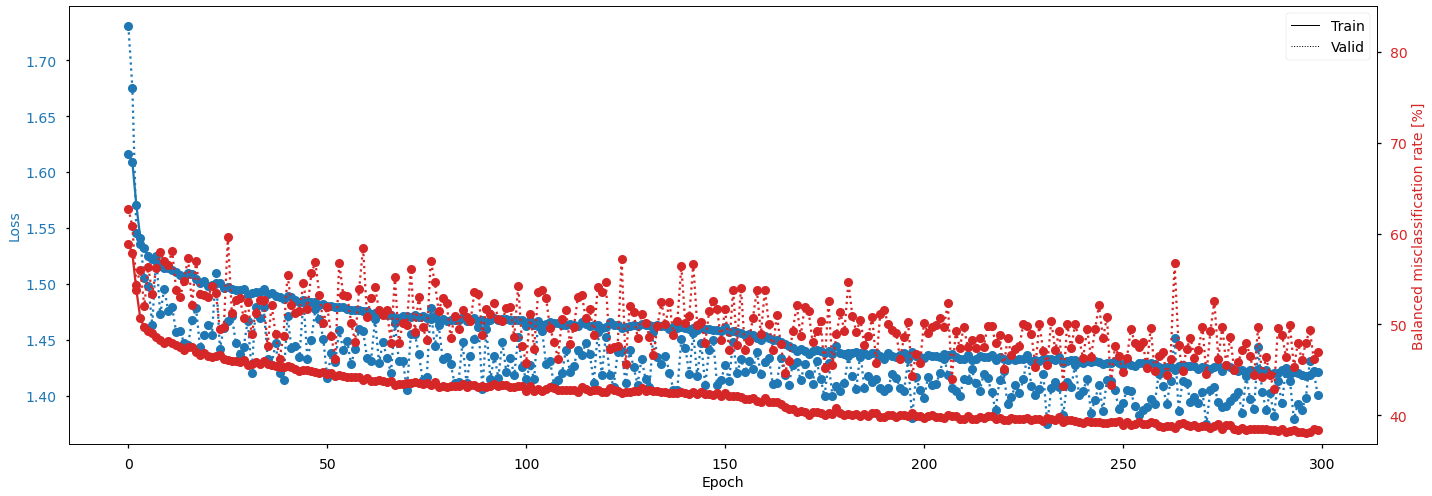

In [ ]:
# Viz of Training
# Wandb may make this unnecessary
training_viz(clf)

In [ ]:
# This was done with the last model - not the one with the best valid bacc
# Prediction on Test Set
y_true = val.y
y_pred = clf.predict(val.X)

print(confusion_matrix(y_true.cpu(), y_pred))
print(classification_report(y_true.cpu(), y_pred))
cohen_kappa = cohen_kappa_score(y_true.cpu(), y_pred)
print(cohen_kappa)

[[4842  863   26   24    1  254]
 [ 186  850  189   26    5  416]
 [  56  673 2859  496   66  885]
 [   3    5  255  355   63   23]
 [   0    0   33  247  133    1]
 [  72  708   65    5    0  757]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      6010
           1       0.27      0.51      0.36      1672
           2       0.83      0.57      0.68      5035
           3       0.31      0.50      0.38       704
           4       0.50      0.32      0.39       414
           5       0.32      0.47      0.38      1607

    accuracy                           0.63     15442
   macro avg       0.53      0.53      0.51     15442
weighted avg       0.73      0.63      0.66     15442

0.5165402314010596


In [ ]:
# Load last checkpointed model
with open('/content/drive/MyDrive/mne_data/fulltrain300_checkpoints/model_289.pkl', 'rb') as f:
    clf2 = pickle.load(f)

# predict on unlabelled
save_fname = "CNN_full_1"
predict_leaderboard_unlabelled(clf2,save_fname)

Sleep leaderboard - Test Data : There are 25748 trials with 2 electrodes and 3000 time samples
(25748, 2, 3000)
Checking if all classes have been predicted
[0 1 2 3 4 5]


In [ ]:
wandb.finish()
# programatically close session
# !kill -9 -1
# !kill $(ps aux | awk '{print $2}')

Load the last model and do TL with data from second group

# 1. Do Full continued training on the second group without freezing any layers

In [ ]:
def get_labels(x):
  return x.y.cpu()
# Load last checkpointed model
# del clf2
with open('/content/drive/MyDrive/mne_data/fulltrain300_checkpoints/model_289.pkl', 'rb') as f:
    clf2 = pickle.load(f)

# In skorch CV split makes only a single split, doesn't try all the different 
# combos since training takes too much time otherwise
# You can use Sklearn to implement it yourself otherwise
# Ref - https://skorch.readthedocs.io/en/stable/user/dataset.html 
# Ref - https://skorch.readthedocs.io/en/stable/dataset.html 
clf2.get_params()
# Params
# Iterator train sampler was custom made giving IDS with train as input
# predet_train_split has reference to val
# clf2.set_params - deactivate predetermined train_split activate 5CV
# clf2.partial_fit() and set warm_start = True

# predict on unlabelled
# save_fname = "CNN_full_1"
# predict_leaderboard_unlabelled(clf2,save_fname)

{'batch_size': 128,
 'callbacks': [('train_bal_acc',
   <skorch.callbacks.scoring.EpochScoring at 0x7feeb886df90>),
  ('valid_bal_acc', <skorch.callbacks.scoring.EpochScoring at 0x7fedb2302f10>),
  ('checkpoint', <skorch.callbacks.training.Checkpoint at 0x7fedb2365c10>),
  ('wandb', <skorch.callbacks.logging.WandbLogger at 0x7fedb22b7e10>)],
 'callbacks__checkpoint': <skorch.callbacks.training.Checkpoint at 0x7fedb2365c10>,
 'callbacks__checkpoint__dirname': '/content/drive/MyDrive/mne_data/fulltrain300_checkpoints',
 'callbacks__checkpoint__event_name': 'event_cp',
 'callbacks__checkpoint__f_criterion': None,
 'callbacks__checkpoint__f_history': 'history.json',
 'callbacks__checkpoint__f_optimizer': None,
 'callbacks__checkpoint__f_params': None,
 'callbacks__checkpoint__f_pickle': 'model_{last_epoch[epoch]}.pkl',
 'callbacks__checkpoint__fn_prefix': '',
 'callbacks__checkpoint__monitor': 'valid_bacc_best',
 'callbacks__checkpoint__sink': <function skorch.utils.noop>,
 'callbacks__epo

In [ ]:
# Create an IDS for the val data
# wandb_run = wandb.init(name = "300 epoch continue train", project='cnn-fulltrain', entity='sleep_hacking')

save_path = "/content/drive/MyDrive/mne_data/fulltrain300_checkpoints"
# cp = Checkpoint(monitor = 'train_bal_acc_best',
#                 f_params = None, f_optimizer = None, f_criterion = None,
#                 f_pickle = "model_{last_epoch[epoch]}.pkl",
#                 dirname = save_path)
cbs = [('train_bal_acc', train_bacc),
            #  ("wandb",WandbLogger(wandb_run))
             ]

clf2.set_params(iterator_train__sampler=IDS(valB,callback_get_label=get_labels),
                train_split = None,
                batch_size = 512, warm_start = True, 
                callbacks = cbs,
                # callbacks__checkpoint = None
                # callbacks__wandb = None
                )

clf2.get_params()

{'batch_size': 512,
 'callbacks': [('train_bal_acc',
   <skorch.callbacks.scoring.EpochScoring at 0x7fef102d8e10>)],
 'callbacks__checkpoint': None,
 'callbacks__epoch_timer': <skorch.callbacks.logging.EpochTimer at 0x7fedb2315a90>,
 'callbacks__print_log': <skorch.callbacks.logging.PrintLog at 0x7fedb22b79d0>,
 'callbacks__print_log__floatfmt': '.4f',
 'callbacks__print_log__keys_ignored': None,
 'callbacks__print_log__sink': <function print>,
 'callbacks__print_log__stralign': 'right',
 'callbacks__print_log__tablefmt': 'simple',
 'callbacks__train_bal_acc': <skorch.callbacks.scoring.EpochScoring at 0x7fef102d8e10>,
 'callbacks__train_bal_acc__lower_is_better': False,
 'callbacks__train_bal_acc__name': 'train_bacc',
 'callbacks__train_bal_acc__on_train': True,
 'callbacks__train_bal_acc__scoring': 'balanced_accuracy',
 'callbacks__train_bal_acc__target_extractor': <function skorch.utils.to_numpy>,
 'callbacks__train_bal_acc__use_caching': True,
 'callbacks__train_loss': <skorch.callb

In [ ]:
n_epochs = 300
clf2.partial_fit(valB,y = None, epochs = n_epochs)

  epoch    train_bacc    train_loss    valid_loss     dur
-------  ------------  ------------  ------------  ------
    291        0.5766        1.4590        1.3820  1.0210
    292        0.5784        1.4572        1.3820  1.0198
    293        0.5793        1.4538        1.3820  0.9915
    294        0.5788        1.4591        1.3820  1.0316
    295        0.5796        1.4531        1.3820  0.9896
    296        0.5866        1.4502        1.3820  0.9866
    297        0.5831        1.4582        1.3820  0.9875
    298        0.5918        1.4415        1.3820  1.1068
    299        0.5892        1.4451        1.3820  1.0369
    300        0.5899        1.4465        1.3820  0.9797
    301        0.5853        1.4496        1.3820  0.9924
    302        0.5924        1.4449        1.3820  1.0161
    303        0.5965        1.4411        1.3820  1.0185
    304        0.5898        1.4452        1.3820  1.0154
    305        0.5990        1.4389        1.3820  1.0145
    306       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=SleepEEG(
    (feature_extractor): Sequential(
      (0): Conv2d(2, 20, kernel_size=(1, 7), stride=(1, 1), groups=2)
      (1): Identity()
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(20, 20, kernel_size=(1, 7), stride=(1, 1), groups=20)
      (5): Identity()
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(20, 20, kernel_size=(1, 5), stride=(1, 1), groups=20)
      (9): Identity()
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(20, 20, kernel_size=(1, 5), stride=(1, 1), groups=20)
      (13): Identity()
      (14): ReLU()
      (15): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (16): Conv2d(20, 20, kernel_size=(1, 5),

In [ ]:
!wandb login

wandb: Currently logged in as: div12345 (use `wandb login --relogin` to force relogin)


In [ ]:
# Save this model once
with open('/content/drive/MyDrive/mne_data/sleepEEGmodel_continue_fulltrain300.pkl', 'wb') as f:
    pickle.dump(clf2, f)

In [ ]:
save_fname = "CNN_full_continue_1"
# predict_leaderboard_unlabelled(clf2,save_fname)
y_pred = clf2.predict(testB.X)
print("Checking if all classes have been predicted")
print(np.unique(y_pred))
# save_fname = "LogReg_newton-cg_1500"
np.savetxt("/content/drive/MyDrive/mne_data/predict/"+save_fname+".txt",y_pred,delimiter=',',fmt="%d")

# testB is loaded


Checking if all classes have been predicted
[0 1 2 3 4 5]


In [ ]:
testB.y.shape

torch.Size([25748])

In [ ]:
wandb.finish()

_runtime,899
_timestamp,1631614308
_step,0


_runtime,▁
_timestamp,▁
_step,▁


# End

The model didn't show much scope for improvement, so moved on to the AttnSleep model